**Week 3: Steepest descent minimization**

Jannek Schaffert, Frédéric Sonak

Background:

Minimization methods are used to find minima in the free energy
landscape of a simulated system, i.e., metastable states, either for assessing the free
energy landscape itself, or to provide a good starting point for MD simulations. 

The Steepest Descent minimization method, named for its approach of moving directly along the gradient of the system’s potential energy, is one of the most widely used techniques due to its computational simplicity and robustness. By following the gradient at each step, Steepest Descent makes consistent progress toward a minimum energy state. This makes it useful in cases where a reliable and straightforward minimization method is needed, especially as a first pass in systems with high initial energy.

However, Steepest Descent has notable limitations. Its strict adherence to moving perpendicular to contour lines results in a “rectangular” or step-like path across the hyperpotential surface, which often leads to slow convergence, particularly in regions with shallow slopes. Another key drawback is that it can only locate the closest local minimum, rather than the global minimum. This means that, depending on the starting structure, the method might converge to a metastable state rather than the most stable configuration. For more efficient and thorough minimization, other algorithms may be employed.

**Task I - Implementation**


Building on the foundation of last week’s sheet, a steepest descent method for position optimisation was implemented. In short this was implemented as follows:
 
Starting with randomly placed particles the full system potential energy was  calculated. Subsequently the force vector for wach particle was calculated.

All the code will be provided in easy to use functions that will be called for Task II.


This markdown was created with the assistance of ChatGPT, focusing on grammar, spelling, and readability.

Importing all external libraries used in this code

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# from numba import njit


import copy
import numpy as np
# import scipy as scy


Creating a particle class:

In [3]:
class Particle:
    """ A round particle with a defined position and velocity\n
    r   : the radius of the particle\n
    pos : the 2-dimensional position of the particle\n
    vel : the x- and y-component of the particle velocity
    """
    def __init__(self, r, m, x, y, vx, vy):
        """Initializing the Particle class.\n
        r       : radius of the particle\n
        x, y    : x and y positions. Don't need to be inside of a box-class\n
        vx, vy  : velocities in x- and y-direction
        """
        self.m = m
        self.r = r
        self.pos = np.array([x,y],dtype=float)
        self.vel = np.array([vx,vy],dtype=float)
        self.acc = np.zeros(2,dtype=float)
        
    def __repr__(self):
        """printing for debugging"""
        return str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.pos[0],self.pos[1],self.vel[0],self.vel[1]))
    
    def move(self, dt = 1., vel = []):
        """moving the particle in the direction, where the velocity-vector points.\n
        dt  : the time-step moving forward; default = 1\n
        vel : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        """
        if len(vel) == 0:
            vel = self.vel
        self.pos += vel*dt

    def calculate_distance(self, particle_1):
        """Calculate the distance to another particle.\n
        particle_1  : The other particle
        """
        return np.sqrt(np.abs(self.pos[0]-particle_1.pos[0])**2+np.abs(self.pos[1]-particle_1.pos[1])**2)



In [4]:

class Box:
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self,box_size):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.
        """
        self.box = box_size
        self.particles: list[Particle] = []
        self.n_particles = 0
        self.forces = np.array([])
        
        
    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f" % (self.box) + ", with %0.2f" % (self.n_particles) + " particles")

    def random_positions(self, axis, n_particles = 0):
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box[axis]-0.5)
        return rnd

    def fill_particles(self, n_particles, radius, mass, vel, angle = [], x = [], y = []):
        """fills the particles-array with particles\n
        n_particles : The amount of particles that should be inserted\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed
        x,y         : initial positions as array of length n; default random positions 0.5 away from border
        """
        self.n_particles = n_particles
        if type(radius) == int or type(radius) == float:
            radius = np.ones(n_particles)*radius
        if type(mass) == int or type(mass) == float:
            mass = np.ones(n_particles)*mass
        if type(vel) == int or type(vel) == float:
            vel = np.ones(n_particles)*vel
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, n_particles)
        
        
        if len(x) == 0:
            x = self.random_positions(0,n_particles)
        if len(y) == 0:
            y = self.random_positions(1,n_particles)
        for i in range(n_particles):
            self.particles.append(Particle(radius[i],mass[i],x[i],y[i],np.sin(angle[i]) * vel[i],np.cos(angle[i]) * vel[i]))
            #print(self.particles[i])
        self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
    
    def fill_grid(self, n_particles:tuple, radius, mass, vel, angle = []):
        """fills the particles-array with particles\n
        n_particles : The amount of particles that should be inserted\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed
        x,y         : initial positions as array of length n; default random positions 0.5 away from border
        """
        self.n_particles = n_particles[0]*n_particles[1]
        if type(radius) == int or type(radius) == float:
            radius = np.ones(self.n_particles)*radius
        if type(mass) == int or type(mass) == float:
            mass = np.ones(self.n_particles)*mass
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
        

        x = []
        y = []
        for i in range(n_particles[0]):
            for j in range(n_particles[1]):
                x.append(self.box[0]/n_particles[0]*i+0.5)
                y.append(self.box[1]/n_particles[1]*j+0.5)

        for i in range(self.n_particles):
            self.particles.append(Particle(radius[i],mass[i],x[i],y[i],np.sin(angle[i]) * vel[i],np.cos(angle[i]) * vel[i]))
            
    

        self.forces = np.ones((self.n_particles, self.n_particles, 2))-1

    def wrap_around(self, particles = []):
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        if len(particles) == 0:
            particles = self.particles
        for i in range(len(particles)):
            particles[i].pos = particles[i].pos % self.box
        return particles

    def reflect(self, particles = []):
        """Reflecting particles on the edges of the box.\n
        particles   : Particles, which should be reflected; default self.particles\n
        returns     : array of particles with new positions
        """
        if len(particles) == 0:
            particles = self.particles
        
        for i in range(len(particles)):
            if (particles[i].pos[0] + particles[i].r) >= self.box[0] or (particles[i].pos[0]) <= particles[i].r:
                particles[i].vel[0] *= (-1)
            if (particles[i].pos[1] + particles[i].r) >= self.box[1] or (particles[i].pos[1]) <= particles[i].r:
                particles[i].vel[1] *= (-1)

        return particles
    
    
    
    def update_forces(self):
        # constants
        c_6 = 6.2647225e3 # g/mol  *  nm**8/ns**2
        c_12 = 9.847044 # g/mol  *  nm**14/ns**2
        

        #iterate through each pairwise interaction
        for i in range(self.forces.shape[0]):
            for j in range(i+1,self.forces.shape[1]):
                #check if particles are closer when wrapped around
                x_equal = False
                y_equal = False
                distance_vector = self.particles[j].pos - self.particles[i].pos
                particle_2 = copy.deepcopy(self.particles[j])
                # if the x or y coordinate is further apart than half the boxwidth, the interaction happens with the ghostparticle in the adjoining compartment
                if distance_vector[0] > self.box[0]/2:
                    particle_2.pos[0] -= self.box[0]
                elif distance_vector[0] < -self.box[0]/2:
                    particle_2.pos[0] += self.box[0]
                elif distance_vector[0] == self.box[0]/2:
                    x_equal = True


                if distance_vector[1] > self.box[1]/2:
                    particle_2.pos[1] -= self.box[1]
                elif distance_vector[1] < -self.box[1]/2:
                    particle_2.pos[1] += self.box[1]
                elif distance_vector[1] == -self.box[1]/2:
                    y_equal = True

                # actually update the forces. Forces are the same between two particles, only the direction changes
                distance_vector = particle_2.pos - self.particles[i].pos
                distance = self.particles[i].calculate_distance(particle_2)
                if x_equal:
                    self.forces[i][j][0] = 0
                    self.forces[j][i][0] = 0
                else:
                    self.forces[i][j][0] = -(12*c_12/distance**14-6*c_6/distance**8)*distance_vector[0]
                    self.forces[j][i][0] = (12*c_12/distance**14-6*c_6/distance**8)*distance_vector[0]
                if y_equal:
                    self.forces[i][j][1] = 0
                    self.forces[j][i][1] = 0
                else:
                    self.forces[i][j][1] = -(12*c_12/distance**14-6*c_6/distance**8)*distance_vector[1]
                    self.forces[j][i][1] = (12*c_12/distance**14-6*c_6/distance**8)*distance_vector[1]
                #save the potential energy as well
        
    def calculate_potential(self):
        # constants
        c_6 = 6.2647225e3 # g/mol  *  nm**8/ns**2
        c_12 = 9.847044 # g/mol  *  nm**14/ns**2
        potential_energy = np.zeros((self.forces.shape[0], self.forces.shape[1]))

        for i in range(self.forces.shape[0]):
            for j in range(i+1,self.forces.shape[1]):
                #check if particles are closer when wrapped around
                x_equal = False
                y_equal = False
                distance_vector = self.particles[j].pos - self.particles[i].pos
                particle_2 = copy.deepcopy(self.particles[j])
                # if the x or y coordinate is further apart than half the boxwidth, the interaction happens with the ghostparticle in the adjoining compartment
                if distance_vector[0] > self.box[0]/2:
                    particle_2.pos[0] -= self.box[0]
                elif distance_vector[0] < -self.box[0]/2:
                    particle_2.pos[0] += self.box[0]
                # cutting the equidistance out, effect is < 10e-12
                '''elif distance_vector[0] == self.box[0]/2:
                    x_equal = True'''


                if distance_vector[1] > self.box[1]/2:
                    particle_2.pos[1] -= self.box[1]
                elif distance_vector[1] < -self.box[1]/2:
                    particle_2.pos[1] += self.box[1]
                '''elif distance_vector[1] == -self.box[1]/2:
                    y_equal = True'''

                # actually update the forces. Forces are the same between two particles, only the direction changes
                distance = self.particles[i].calculate_distance(particle_2)
                potential_energy[i][j] = -(-c_12/distance**12+c_6/distance**6)
                potential_energy[j][i] = -(-c_12/distance**12+c_6/distance**6)
        return potential_energy
        
    



In the next code snipped definitions from the previous excercise were included. In addition an implementation of the steepest descent algorythm was implemented. 

In [19]:
from math import nan


class Simulation:
    """Simulation class for everything related to simulating the particles in a box\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    data_traj   : The trajectories of all particles
    """
    def __init__(self, box:Box, steps, dt):
        """Initializing the Simulation\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    """
        self.box:Box = box
        self.steps = steps
        self.dt = dt
        self.pot_energy = np.array([])
        self.kin_energy = np.array([])
        self.data_traj  = np.array([])
        self.set_traj()

    def set_traj(self):
        """Initialize the trajectory-saving"""
        self.data_traj  = np.zeros((self.box.n_particles, 6, self.steps+1))
        self.pot_energy = np.zeros((self.steps+1, self.box.n_particles, self.box.n_particles))
        self.kin_energy = np.zeros((self.steps+1, self.box.n_particles))

    def collision(self, particle_1, particle_2):
        """Collide two particles without considering wether overlap exists.\n
        particles   : two particles that collide.
        """
        # calculate angle between x-axis and line between particles
        phi = np.arctan((particle_2.pos[1] - particle_1.pos[1])/(particle_2.pos[0] - particle_1.pos[0]))
        # change the velocities
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        # Get the velocities of particles i and j as variables
        v1x, v1y = particle_1.vel[0], particle_1.vel[1]
        v2x, v2y = particle_2.vel[0], particle_2.vel[1]

        # Calculate the updated velocities using the provided formulas: https://hermann-baum.de/elastischer_stoss/
        # the tangental part stays the same, the normal part changes. This is done in transformed coordinates and then transformed directly back
        new_v1x = ( v1x * sin_phi - v1y * cos_phi) * sin_phi + (v2x * cos_phi + v2y * sin_phi) * cos_phi
        new_v1y = (-v1x * sin_phi + v1y * cos_phi) * cos_phi + (v2x * cos_phi + v2y * sin_phi) * sin_phi
        new_v2x = ( v2x * sin_phi - v2y * cos_phi) * sin_phi + (v1x * cos_phi + v1y * sin_phi) * cos_phi
        new_v2y = (-v2x * sin_phi + v2y * cos_phi) * cos_phi + (v1x * cos_phi + v1y * sin_phi) * sin_phi

        # Update the particles' velocities
        particle_1.vel[0], particle_1.vel[1] = new_v1x, new_v1y
        particle_2.vel[0], particle_2.vel[1] = new_v2x, new_v2y
        return particle_1, particle_2

    def collide_simple(self, particles):
        """Initial idea on how collision works.\n
        particles   : All particles for which the collision should happen
        """
        for i in range(len(particles)): # looping through all particles
            for j in range(i,len(particles)):
                if particles[i].calculate_distance(particles[j])<(particles[i].r+particles[j].r):
                    particles[i], particles[j] = self.collision(particles[i], particles[j])

    def check_overlap(self, particle_1, particle_2):
        """Check if two particles overlap\n
        particles   : two particles to check wether they overlap
        """
        # how far apart the particles should be on impact
        R = particle_1.r+particle_2.r
        if particle_1.calculate_distance(particle_2)<R:
            return True
        else:
            return False

    def collision_complex(self, particle_1, particle_2):
        """The more complex version of collisions. This includes time-warping two colliding particles backwards, so that they don't overlap. After the collision, time is warped forward again.\n
        particles   : two particles that get checked if they should collide
        """
        if self.check_overlap(particle_1,particle_2):
            #print(step)
            #print(particle_1, particle_2,'collided with a distance of ', particle_1.calculate_distance(particle_2))
            
            # in time
            # defining re-used variables
            velocity_vector = particle_1.vel-particle_2.vel     # von j nach i
            distance_vector = particle_2.pos-particle_1.pos     # von i nach j
            R = particle_1.r+particle_2.r

            #calculating the time needed to travel back in two steps:
            
            sqrt = 2*np.sqrt((distance_vector[0]*velocity_vector[0]+distance_vector[1]*velocity_vector[1])**2-
                             (velocity_vector[0]**2+velocity_vector[1]**2)*(distance_vector[0]**2+distance_vector[1]**2-R**2))
            

            delta_t = -1*(-2*(distance_vector[0]*velocity_vector[0]+distance_vector[1]*velocity_vector[1]) + sqrt)/(2*(velocity_vector[0]**2+velocity_vector[1]**2))

            #solving the quadratic equation results in two solutions (one positive and one negative), we want the negative solution, for backwards time-travel
            if delta_t > 0:
                delta_t = -1*(-2*(distance_vector[0]*velocity_vector[0]+distance_vector[1]*velocity_vector[1]) - sqrt)/(2*(velocity_vector[0]**2+velocity_vector[1]**2))
            
            # rewind time to just outside of the collision
            particle_1.move(delta_t)
            particle_2.move(delta_t)

            # change the velocities
            particle_1, particle_2 = self.collision(particle_1, particle_2)
            
            # finish this time_step, that was rewound previously and open the boundaries again with np.mod
            particle_1.move(-delta_t)
            particle_2.move(-delta_t)

    def collide_border_check(self,i):
        """Check if there are particles that might collide with particles on the opposite side of the box"""
        #run through all pairwise possible interactions and check collisions
            # account for edge cases
        moved = False
        if self.box.particles[i].pos[0] < self.box.particles[i].r:
            self.box.particles[i].pos[0] += self.box.box[0]
            moved = True
        elif self.box.particles[i].pos[0] > self.box.box[0]-self.box.particles[i].r:
            self.box.particles[i].pos[0] -= self.box.box[0]
            moved = True

        if self.box.particles[i].pos[1] < self.box.particles[i].r:
            self.box.particles[i].pos[1] += self.box.box[1]
            moved = True
        elif self.box.particles[i].pos[1] > self.box.box[1]-self.box.particles[i].r:
            self.box.particles[i].pos[1] -= self.box.box[1]
            moved = True
        if moved:
            for j in range(i+1,len(self.box.particles)):
                self.collision_complex(self.box.particles[i],self.box.particles[j])
                self.box.particles = self.box.wrap_around()

    def check_collisions(self):
        """check for collisions between all particles"""
        for i in range(self.box.n_particles):
            for j in range(i+1,self.box.n_particles):
                self.collision_complex(self.box.particles[i], self.box.particles[j])
                self.box.particles = self.box.wrap_around()
            self.collide_border_check(i)
            self.box.particles = self.box.wrap_around()

    def run(self, force_type = 'billiard'):
        """runs the simulation with the given parameters of the simulation"""
        self.set_traj()
        if force_type == 'billiard':
            for j in range(self.box.n_particles):
                self.data_traj[j,:,0] = [self.box.particles[j].pos[0], self.box.particles[j].pos[1], self.box.particles[j].vel[0], self.box.particles[j].vel[1], self.box.particles[j].acc[0], self.box.particles[j].acc[1]]
            for i in range(self.steps):
                for j in range(self.box.n_particles):
                    self.box.particles[j].move(self.dt)
                self.box.particles = self.box.wrap_around()
                self.check_collisions()
                for j in range(self.box.n_particles):
                    self.data_traj[j,:,i+1] = [self.box.particles[j].pos[0], self.box.particles[j].pos[1], self.box.particles[j].vel[0], self.box.particles[j].vel[1], self.box.particles[j].acc[0], self.box.particles[j].acc[1]]
        elif force_type == 'lennard-jones':
            # initialize the forces/acceleration for initial time step
            self.box.update_forces()
            self.pot_energy[0] = self.box.calculate_potential()
            for j in range(self.box.n_particles):
                self.box.particles[j].acc = np.sum(self.box.forces[j],axis=0)/self.box.particles[j].m
                self.data_traj[j,:,0] = [self.box.particles[j].pos[0], self.box.particles[j].pos[1], self.box.particles[j].vel[0], self.box.particles[j].vel[1], self.box.particles[j].acc[0], self.box.particles[j].acc[1]]
                self.kin_energy[0][j] = 1/2*self.box.particles[j].m*(np.linalg.norm(self.box.particles[j].vel))**2
            # loop through all time steps
            for i in range(self.steps):
                # update positions
                self.update_positions()
                # update forces, acceleration and velocities. Save the current potential energy between each particle pair
                self.update_velocities()
                self.pot_energy[i+1] = self.box.calculate_potential()
                # save the trajectories and calculate the kinetic energy
                for j in range(self.box.n_particles):
                    #print(j,self.box.particles[j].pos,self.box.particles[j].vel,self.box.particles[j].acc)
                    self.data_traj[j,:,i+1] = [self.box.particles[j].pos[0], self.box.particles[j].pos[1], self.box.particles[j].vel[0], self.box.particles[j].vel[1], self.box.particles[j].acc[0], self.box.particles[j].acc[1]]
                    self.kin_energy[i+1][j] = 1/2*self.box.particles[j].m*(np.linalg.norm(self.box.particles[j].vel))**2

    def update_positions(self):
        """Updates the position of the particles"""
        for j in range(self.box.n_particles):
            self.box.particles[j].pos = self.box.particles[j].pos + self.box.particles[j].vel*self.dt + 1/2*(self.box.particles[j].acc*self.dt**2)
        self.box.wrap_around()

    def update_velocities(self):
        """Changes the forces, acceleration and velocities. \n
        returns the potential energy of all particles with all particles as a nxn matrix"""
        self.box.update_forces()
        for j in range(self.box.forces.shape[1]):
            new_acc = np.sum(self.box.forces[j],axis=0)/self.box.particles[j].m
            self.box.particles[j].vel = self.box.particles[j].vel + 1/2*(self.box.particles[j].acc + new_acc)*self.dt
            self.box.particles[j].acc = new_acc
    
    
    
    
    def steepest_descent(self, distance = 0.05, counter = 30, verbose = False):
        pot_energies = []
        self.box.update_forces()
        pot_energies.append(np.sum(self.box.calculate_potential())/2)
        pot_energy_old = 0
        self.set_traj()
        '''for j in range(self.box.n_particles):
            self.data_traj[j,:,0] = [self.box.particles[j].pos[0], self.box.particles[j].pos[1], self.box.particles[j].vel[0], self.box.particles[j].vel[1], self.box.particles[j].acc[0], self.box.particles[j].acc[1]]'''
        while counter > 0:
            move_direction = np.sum(self.box.forces,axis=1)
            if verbose:
                print(move_direction)
            for i in range(len(move_direction)):
                move_direction[i] = move_direction[i] / np.linalg.norm(move_direction[i])
            pathway = True
            
            while pathway:
                for j in range(self.box.n_particles):
                    self.box.particles[j].move(dt=distance, vel=move_direction[j])
                pot_energy_new = np.sum(self.box.calculate_potential())/2
                if verbose:
                    print(counter,pot_energy_new)
                if pot_energy_new < pot_energies[-1]:
                    pot_energies.append(pot_energy_new)
                    '''for j in range(self.box.n_particles):
                        #print(j,self.box.particles[j].pos,self.box.particles[j].vel,self.box.particles[j].acc)
                        self.data_traj[j,:,i+1] = [self.box.particles[j].pos[0], self.box.particles[j].pos[1], self.box.particles[j].vel[0], self.box.particles[j].vel[1], self.box.particles[j].acc[0], self.box.particles[j].acc[1]]
                    '''    
                else:
                    pathway = False
                    counter -= 1
                    for j in range(self.box.n_particles):
                        self.box.particles[j].move(dt=-distance, vel=move_direction[j])
                    # pot_energies.append(pot_energy_new)
                    self.box.update_forces()
            if np.abs(pot_energy_new - pot_energies[-1]) < 0.001 or pot_energy_new==pot_energy_old:
                print('Ending steepest descent; reached local minimum')
                counter = -1
            else:
                pot_energy_old = pot_energy_new
                if verbose:
                    print(counter,pot_energies[-1])
        return pot_energies


    def show_traj(self):
        """Shows a 2D-plot of all trajectories"""
        for data_traj_j in self.data_traj:
            plt.plot(data_traj_j[0],data_traj_j[1],'-')
        plt.xlabel('position x')
        plt.ylabel('position y')

        plt.grid()
        plt.show()
        
    def setup(self):
        """setup the animation"""
        self.fig, self.ax = plt.subplots()

        self.ax.set_xlim((0, self.box.box[0]))
        self.ax.set_ylim((0, self.box.box[1]))

        plt.xlabel('position x')
        plt.ylabel('position y')

        # make the points in the plot the correct size according to the radius of the particles
        # use ax.transData.transform to convert radius size from particle to markerSize from pyplot
        desired_size_in_data_units = self.box.particles[0].r/6
        data_to_points = self.ax.transData.transform((desired_size_in_data_units, 0)) - self.ax.transData.transform((0, 0))
        marker_size_in_points = data_to_points[0]
        
        self.dot, = self.ax.plot([], [], 'bo', ms=marker_size_in_points)
        
    def init_vid(self):
        """initialize the video"""
        self.dot.set_data([], [])
        return (self.dot,)
    # animation function. This is called sequentially
    def animate(self,i):
        """animate the video"""
        x = self.data_traj[:,0,i]
        y = self.data_traj[:,1,i]
        self.dot.set_data(x, y)
        return (self.dot,)
    def animation(self, save_pls = False):
        """create and save a video of the simulation"""
        self.setup()
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init_vid, frames=self.steps, interval=60, blit=True)
        HTML(anim.to_html5_video())

        # uncomment if video should not be saved
        if save_pls:
            anim.save('animation.mp4', fps=30)
    


    def plot_energies(self):
        fig, ax = plt.subplots(figsize=(16, 9))

        ax.plot(np.linspace(0,self.steps,self.steps+1),np.sum(np.sum(self.pot_energy,axis=1),axis=1)/2,label='pot')
        ax.plot(np.linspace(0,self.steps,self.steps+1),np.sum(self.kin_energy,axis=1),label='kin')
        ax.plot(np.linspace(0,self.steps,self.steps+1),np.sum(self.kin_energy,axis=1)+np.sum(np.sum(self.pot_energy,axis=1),axis=1)/2,label='com')

        ax.set_xlabel('time [s]')
        ax.set_ylabel('energy [g/mol m/s]')

        plt.legend()




**Task II - Running the simulation** 

For the simulation a box with the dimensions 5 x 5 nm and periodic boundary conditions was created. 50 Particles, each with a mass of 18 g/mol were created and placed randomly. As with a previous excercise the interaction was modeled as a Lennard-Jones potential with the corresponding constants. A velocity with magnitude 150 nm/ns and a random direction distribution was initially placed on each particle. The simulation was run for 20000 steps with a time step of $\Delta t$ = 2 fs. For each step the kinetic and potential energy was calculated.

In [20]:
# defining the box
box_size = [5,5]#nm

box = Box(box_size)


number_of_particles = 50
grid_particles = (7,7)

radius = 0.5
mass = 18 #g/mol
vel = np.ones(number_of_particles)*150 # nm/ns
angles = np.random.uniform(0,2*np.pi,number_of_particles)

angles = [np.pi/4,-np.pi/4]
x = [2.75,3.25]
y = [1.5,1.5]

#box.fill_grid(grid_particles,radius,mass,vel)#,angles,x,y)

box.fill_particles(number_of_particles,radius,mass,vel)#,angles,x,y)



In [21]:
# Defining number of simulation steps
steps = 2000
dt = 2e-6 #ns
sim = Simulation(box, steps, dt) 

2834431119482300.0


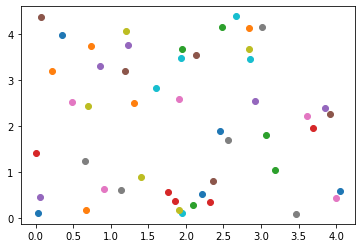

In [13]:
print(np.sum(sim.box.calculate_potential())/2)
for i in range(len(sim.box.particles)):
    plt.scatter(sim.box.particles[i].pos[0],sim.box.particles[i].pos[1])

In [14]:
energies = sim.steepest_descent(0.001, 1000)
#energies

Ending steepest descent; reached local minimum


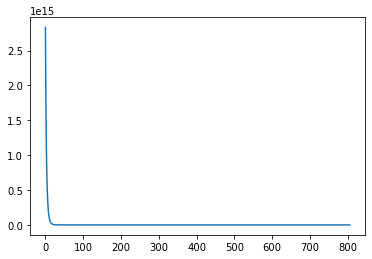

In [15]:
plt.plot(energies)

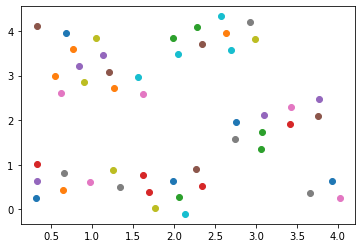

In [16]:
for i in range(len(sim.box.particles)):
    plt.scatter(sim.box.particles[i].pos[0],sim.box.particles[i].pos[1])

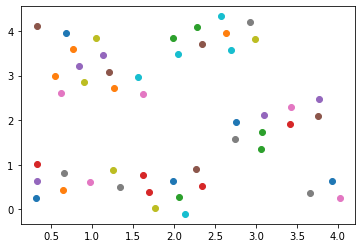

In [17]:
for i in range(len(sim.box.particles)):
    plt.scatter(sim.box.particles[i].pos[0],sim.box.particles[i].pos[1])

In [18]:
sim.run('lennard-jones')
#sim.run()

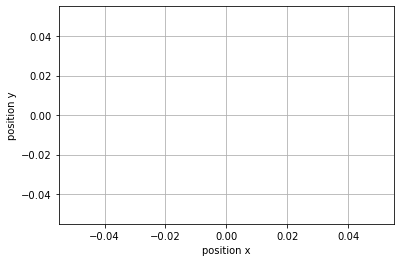

In [22]:
sim.show_traj()

In [40]:
#sim.animation(True)

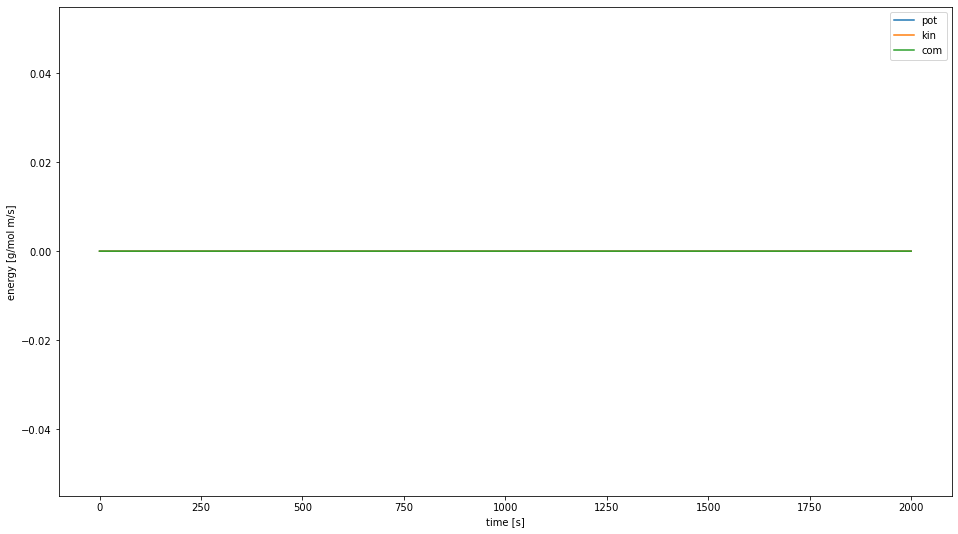

In [23]:
sim.plot_energies()